In [20]:
# Instalarea pachetelor necesare pentru analiza econometrică și modele ML.

!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [21]:
# Importul bibliotecilor utilizate pentru gestionarea datelor,vizualizare și estimarea modelelor de învățare automată.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

In [22]:
# Definirea adresei de bază către fișierele procesate.
# Simplifică gestionarea celor patru variante de seturi de date: RAW, LOG, PCA și CLUSTERS.

BASE_URL = "https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/"

RAW_TRAIN_FILE   = "train_data_raw.csv"
RAW_TEST_FILE    = "test_data_raw.csv"

LOG_TRAIN_FILE   = "train_data_log.csv"
LOG_TEST_FILE    = "test_data_log.csv"

PCA_TRAIN_FILE   = "train_data_pca.csv"
PCA_TEST_FILE    = "test_data_pca.csv"

CLUST_TRAIN_FILE = "train_data_clusters.csv"
CLUST_TEST_FILE  = "test_data_clusters.csv"

urls = {
    "raw_train":   BASE_URL + RAW_TRAIN_FILE,
    "raw_test":    BASE_URL + RAW_TEST_FILE,
    "log_train":   BASE_URL + LOG_TRAIN_FILE,
    "log_test":    BASE_URL + LOG_TEST_FILE,
    "pca_train":   BASE_URL + PCA_TRAIN_FILE,
    "pca_test":    BASE_URL + PCA_TEST_FILE,
    "clust_train": BASE_URL + CLUST_TRAIN_FILE,
    "clust_test":  BASE_URL + CLUST_TEST_FILE,
}

In [23]:
# Încărcarea centralizată a seturilor de date într-o structură de tip dicționar,
# pentru a facilita aplicarea uniformă a metodelor ML pe fiecare variantă.

datasets = {}
for name, url in urls.items():
    print(f"Încărcare {name} din {url}")
    df = pd.read_csv(url)
    print(f"  Dimensiune: {df.shape}")
    datasets[name] = df

print("\nColoane RAW train:", datasets["raw_train"].columns.tolist())
print("Coloane LOG train:", datasets["log_train"].columns.tolist())
print("Coloane CLUST train:", datasets["clust_train"].columns.tolist())
print("Coloane PCA train:", datasets["pca_train"].columns.tolist())

Încărcare raw_train din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/train_data_raw.csv
  Dimensiune: (111, 9)
Încărcare raw_test din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/test_data_raw.csv
  Dimensiune: (24, 9)
Încărcare log_train din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/train_data_log.csv
  Dimensiune: (111, 13)
Încărcare log_test din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/test_data_log.csv
  Dimensiune: (24, 13)
Încărcare pca_train din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/train_data_pca.csv
  Dimensiune: (111, 8)
Încărcare pca_test din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/main/data/processed/test_data_pca.csv
  Dimensiune: (24, 8)
Încărcare clust_train din https://raw.githubusercontent.com/antoniamitu/proiect_econometrie/mai

In [24]:
# Definirea indicatorului MAPE (Mean Absolute Percentage Error),
# utilizat pentru evaluarea relativă a performanței de predicție.

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Funcție generică ce aplică un set standard de modele ML pe un anumit dataset
# și returnează un tabel cu indicatori de performanță comparabili.

def run_all_models(X_train, y_train, X_test, y_test, label, scale_X=True):

    if scale_X:
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s  = scaler.transform(X_test)
    else:
        X_train_s, X_test_s = X_train, X_test

    results = []
    alphas = np.logspace(-4, 4, 100)

    # Ridge
    ridge = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridge.fit(X_train_s, y_train)
    pred = ridge.predict(X_test_s)
    results.append(["Ridge", label, ridge.alpha_,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    # Lasso
    lasso = LassoCV(alphas=alphas, cv=5, random_state=42)
    lasso.fit(X_train_s, y_train)
    pred = lasso.predict(X_test_s)
    results.append(["Lasso", label, lasso.alpha_,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    # Elastic Net
    enet = ElasticNetCV(l1_ratio=np.linspace(0.1,1,10), alphas=alphas, cv=5, random_state=42)
    enet.fit(X_train_s, y_train)
    pred = enet.predict(X_test_s)
    results.append(["ElasticNet", label, enet.alpha_,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(
        rf,
        {"n_estimators":[100,200],
         "max_depth":[None,4,6]},
        cv=5, scoring="neg_mean_squared_error", n_jobs=-1
    )
    rf_grid.fit(X_train_s, y_train)
    pred = rf_grid.best_estimator_.predict(X_test_s)
    results.append(["RandomForest", label, None,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    # Gradient Boosting
    gbr = GradientBoostingRegressor(random_state=42)
    gbr_grid = GridSearchCV(
        gbr,
        {"n_estimators":[100,200],
         "learning_rate":[0.05,0.1],
         "max_depth":[2,3]},
        cv=5, scoring="neg_mean_squared_error", n_jobs=-1
    )
    gbr_grid.fit(X_train_s, y_train)
    pred = gbr_grid.best_estimator_.predict(X_test_s)
    results.append(["GradientBoosting", label, None,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    # SVR
    svr = SVR(kernel="rbf")
    svr_grid = GridSearchCV(
        svr,
        {"C":[1,10,100],
         "epsilon":[0.01,0.1,0.5],
         "gamma":["scale","auto"]},
        cv=5, scoring="neg_mean_squared_error", n_jobs=-1
    )
    svr_grid.fit(X_train_s, y_train)
    pred = svr_grid.best_estimator_.predict(X_test_s)
    results.append(["SVR", label, None,
                    np.sqrt(mean_squared_error(y_test, pred)),
                    mean_absolute_error(y_test, pred),
                    mape(y_test, pred), r2_score(y_test, pred)])

    return pd.DataFrame(results, columns=["Model","Dataset","Alpha","RMSE","MAE","MAPE","R2"])

In [25]:
# Pregătirea setului RAW: eliminarea variabilelor de identificare
# și codificarea variabilei categoriale D într-un indicator binar numeric.

raw_train = datasets["raw_train"].copy()
raw_test  = datasets["raw_test"].copy()

# Eliminarea identificatorilor ne-numerici
raw_train = raw_train.drop(columns=["iso_code", "country"])
raw_test  = raw_test.drop(columns=["iso_code", "country"])

# Codificarea variabilei D: HighFreedom = 1, LowFreedom = 0
mapping_D = {"LowFreedom": 0, "HighFreedom": 1}
raw_train["D_bin"] = raw_train["D"].map(mapping_D)
raw_test["D_bin"]  = raw_test["D"].map(mapping_D)

# Definirea variabilei țintă și a predictorilor
raw_target_col  = "Y"
raw_feature_cols = ["X1", "X2", "X3", "X4", "X5", "D_bin"]

X_train_raw = raw_train[raw_feature_cols]
y_train_raw = raw_train[raw_target_col]

X_test_raw = raw_test[raw_feature_cols]
y_test_raw = raw_test[raw_target_col]

print("Features RAW:", raw_feature_cols)
print("y RAW: Y")

Features RAW: ['X1', 'X2', 'X3', 'X4', 'X5', 'D_bin']
y RAW: Y


In [26]:
# Estimarea modelelor ML pe varianta RAW a datelor,
# utilizând aceeași împărțire train/test ca în modelele clasice.

results_raw = run_all_models(
    X_train=X_train_raw,
    y_train=y_train_raw,
    X_test=X_test_raw,
    y_test=y_test_raw,
    label="RAW",
    scale_X=True
)

print("Rezultate ML – set RAW:")
display(results_raw)

Rezultate ML – set RAW:


,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
0,Ridge,RAW,31.257158,26.790890,21.949477,55.557386,0.050697
1,Lasso,RAW,0.247708,28.193128,22.667262,56.998375,-0.051277
2,ElasticNet,RAW,0.432876,26.591354,21.850806,55.326086,0.064785
3,RandomForest,RAW,NaN,30.517638,25.973409,66.873504,-0.231778
4,GradientBoosting,RAW,NaN,37.547032,29.758752,73.336303,-0.864583
5,SVR,RAW,NaN,27.709930,22.054738,53.547290,-0.015550


In [27]:
# Pregătirea setului LOG: se utilizează variabila dependentă logaritmată l_Y
# și un amestec de predictori în nivel și logaritmați, conform specificației teoretice.

log_train = datasets["log_train"].copy()
log_test  = datasets["log_test"].copy()

# Eliminarea identificatorilor
log_train = log_train.drop(columns=["iso_code", "country"])
log_test  = log_test.drop(columns=["iso_code", "country"])

# Codificarea variabilei D
log_train["D_bin"] = log_train["D"].map(mapping_D)
log_test["D_bin"]  = log_test["D"].map(mapping_D)

# Variabilă dependentă: l_Y (log-ul depozitelor)
log_target_col = "l_Y"

# Predictori: variabilele logaritmate și scorurile X3, X4 + D_bin
log_feature_cols = ["l_X1", "l_X2", "X3", "X4", "l_X5", "D_bin"]

X_train_log = log_train[log_feature_cols]
y_train_log = log_train[log_target_col]

X_test_log = log_test[log_feature_cols]
y_test_log = log_test[log_target_col]

print("Features LOG:", log_feature_cols)
print("y LOG: l_Y (log depozite)")

Features LOG: ['l_X1', 'l_X2', 'X3', 'X4', 'l_X5', 'D_bin']
y LOG: l_Y (log depozite)


In [28]:
# Estimarea modelelor ML pe varianta logaritmată a datelor.
# Evaluarea se realizează inițial în log-scale, ceea ce corespunde
# modelării logaritmului depozitelor.

results_log_logscale = run_all_models(
    X_train=X_train_log,
    y_train=y_train_log,
    X_test=X_test_log,
    y_test=y_test_log,
    label="LOG (log-scale)",
    scale_X=True
)

print("Rezultate ML – set LOG (log-scale):")
display(results_log_logscale)

Rezultate ML – set LOG (log-scale):


,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
0,Ridge,LOG (log-scale),31.257158,0.430240,0.351392,9.437808,0.248251
1,Lasso,LOG (log-scale),0.031993,0.432679,0.357941,9.594278,0.239705
2,ElasticNet,LOG (log-scale),0.117681,0.431821,0.357098,9.578803,0.242717
3,RandomForest,LOG (log-scale),NaN,0.508404,0.432468,11.589339,-0.049707
4,GradientBoosting,LOG (log-scale),NaN,0.554164,0.452847,12.177611,-0.247173
5,SVR,LOG (log-scale),NaN,0.483117,0.388009,10.498657,0.052118


In [29]:
# În această etapă se ilustrează, pentru modelul Ridge, modul în care
# predicțiile obținute în log-scale pot fi transformate înapoi în nivel,
# pentru a compara erorile raportate la Y în unitățile sale originale.

alphas = np.logspace(-4, 4, 100)
scaler_log = StandardScaler()
X_train_log_s = scaler_log.fit_transform(X_train_log)
X_test_log_s  = scaler_log.transform(X_test_log)

ridge_log = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_log.fit(X_train_log_s, y_train_log)
ridge_log_pred_log = ridge_log.predict(X_test_log_s)

# Revenirea la nivel utilizând exponentiala
ridge_log_pred_level = np.exp(ridge_log_pred_log)
y_test_level         = log_test["Y"].values  # Y în nivel, din fișierul LOG

ridge_log_rmse_level = np.sqrt(mean_squared_error(y_test_level, ridge_log_pred_level))
ridge_log_mae_level  = mean_absolute_error(y_test_level, ridge_log_pred_level)
ridge_log_mape_level = mape(y_test_level, ridge_log_pred_level)
ridge_log_r2_level   = r2_score(y_test_level, ridge_log_pred_level)

print("Ridge LOG (revenit la nivel):",
      "\n  RMSE:", ridge_log_rmse_level,
      "\n  MAE :", ridge_log_mae_level,
      "\n  MAPE:", ridge_log_mape_level,
      "\n  R2  :", ridge_log_r2_level)

Ridge LOG (revenit la nivel): 
  RMSE: 23.754230642413777 
  MAE : 18.974200187176766 
  MAPE: 41.04275135085775 
  R2  : 0.25370160627885596


In [30]:
# Pregătirea setului CLUSTERS, ce conține reprezentanți de cluster.
# Clasa de cluster este inclusă ca predictor suplimentar, captând
# apartenența observațiilor la segmente omogene.

clust_train = datasets["clust_train"].copy()
clust_test  = datasets["clust_test"].copy()

clust_train = clust_train.drop(columns=["iso_code", "country"])
clust_test  = clust_test.drop(columns=["iso_code", "country"])

clust_target_col  = "Y"
clust_feature_cols = ["X1", "X2", "X3", "X4", "X5", "Cluster"]

X_train_clust = clust_train[clust_feature_cols]
y_train_clust = clust_train[clust_target_col]

X_test_clust = clust_test[clust_feature_cols]
y_test_clust = clust_test[clust_target_col]

print("Features CLUSTERS:", clust_feature_cols)
print("y CLUSTERS: Y")

Features CLUSTERS: ['X1', 'X2', 'X3', 'X4', 'X5', 'Cluster']
y CLUSTERS: Y


In [31]:
# Estimarea modelelor ML pe setul de date agregat pe clustere,
# pentru a evalua robustețea rezultatelor la structurarea pe grupuri.

results_clust = run_all_models(
    X_train=X_train_clust,
    y_train=y_train_clust,
    X_test=X_test_clust,
    y_test=y_test_clust,
    label="CLUSTERS",
    scale_X=True
)

print("Rezultate ML – set CLUSTERS:")
display(results_clust)

Rezultate ML – set CLUSTERS:


,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
0,Ridge,CLUSTERS,31.257158,27.103766,22.009559,56.179067,0.028395
1,Lasso,CLUSTERS,0.081113,28.313374,22.346166,56.969877,-0.060264
2,ElasticNet,CLUSTERS,0.359381,27.002551,21.977593,56.076768,0.035638
3,RandomForest,CLUSTERS,NaN,28.909660,25.182689,63.872720,-0.105393
4,GradientBoosting,CLUSTERS,NaN,32.981771,28.468272,69.358416,-0.438727
5,SVR,CLUSTERS,NaN,26.636700,22.270690,53.834628,0.061593


In [32]:
# Pregătirea setului PCA, în care informația din variabilele explicative
# este condensată în componente principale ortogonale.

pca_train = datasets["pca_train"].copy()
pca_test  = datasets["pca_test"].copy()

pca_train = pca_train.drop(columns=["iso_code", "country"])
pca_test  = pca_test.drop(columns=["iso_code", "country"])

# Codificarea variabilei D și includerea ei alături de componentele principale.
pca_train["D_bin"] = pca_train["D"].map(mapping_D)
pca_test["D_bin"]  = pca_test["D"].map(mapping_D)

pca_target_col   = "l_Y"
pca_feature_cols = ["PC1", "PC2", "PC3", "PC4", "D_bin"]

X_train_pca = pca_train[pca_feature_cols]
y_train_pca = pca_train[pca_target_col]

X_test_pca = pca_test[pca_feature_cols]
y_test_pca = pca_test[pca_target_col]

print("Features PCA:", pca_feature_cols)
print("y PCA: l_Y")

Features PCA: ['PC1', 'PC2', 'PC3', 'PC4', 'D_bin']
y PCA: l_Y


In [33]:
# Aplicarea modelelor ML pe datele reduse dimensional prin PCA,
# utilizând logaritmul depozitelor ca variabilă dependentă.

results_pca = run_all_models(
    X_train=X_train_pca,
    y_train=y_train_pca,
    X_test=X_test_pca,
    y_test=y_test_pca,
    label="PCA (log-scale)",
    scale_X=True
)

print("Rezultate ML – set PCA:")
display(results_pca)

Rezultate ML – set PCA:


,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
0,Ridge,PCA (log-scale),1.917910,0.423507,0.343959,9.264238,0.271598
1,Lasso,PCA (log-scale),0.081113,0.441586,0.362650,9.689303,0.208081
2,ElasticNet,PCA (log-scale),0.081113,0.441586,0.362650,9.689303,0.208081
3,RandomForest,PCA (log-scale),NaN,0.463239,0.377991,10.164882,0.128514
4,GradientBoosting,PCA (log-scale),NaN,0.451135,0.370936,10.032711,0.173459
5,SVR,PCA (log-scale),NaN,0.522017,0.426183,11.520630,-0.106674


In [35]:
# Agregarea rezultatelor într-un tabel unic pentru toate tipurile de preprocesare.
# Acest rezumat facilitează comparația directă între performanțele modelelor
# în funcție de transformările aplicate setului de date.

all_results = pd.concat(
    [results_raw, results_log_logscale, results_clust, results_pca],
    ignore_index=True
)

def pretty_table(df, caption="Rezultate modele ML"):
    return (df.style
        .set_caption(caption)
        .format({
            "RMSE": "{:.4f}",
            "MAE": "{:.4f}",
            "MAPE": "{:.2f}",
            "R2": "{:.3f}",
            "Alpha": lambda x: "-" if pd.isna(x) else f"{x:.6f}"
        })
        .background_gradient(subset=["RMSE"], cmap="Blues_r")
        .background_gradient(subset=["R2"], cmap="Greens")
        .background_gradient(subset=["MAPE"], cmap="Oranges_r")
        .highlight_min(subset=["RMSE"], color="lightgreen")
        .highlight_max(subset=["R2"], color="lightgreen")
        .set_properties(**{
            "border": "1px solid #999",
            "text-align": "center",
            "padding": "6px"
        })
        .set_table_styles([
            {"selector": "caption",
             "props": [("color", "#333"),
                       ("font-size", "16px"),
                       ("text-align", "center"),
                       ("margin-bottom", "10px"),
                       ("font-weight", "bold")]}
        ])
    )

display(pretty_table(all_results, "📊 Rezultate complete – toate seturile"))


# Ordonarea modelelor după RMSE pentru identificarea celor mai bune specificații predictive.
all_results_sorted = all_results.sort_values(by="RMSE")
display(pretty_table(all_results_sorted, "🏆 Modele ordonate după RMSE (cel mai bun → cel mai mic)"))



,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
0,Ridge,RAW,31.257158,26.7909,21.9495,55.56,0.051
1,Lasso,RAW,0.247708,28.1931,22.6673,57.00,-0.051
2,ElasticNet,RAW,0.432876,26.5914,21.8508,55.33,0.065
3,RandomForest,RAW,-,30.5176,25.9734,66.87,-0.232
4,GradientBoosting,RAW,-,37.5470,29.7588,73.34,-0.865
5,SVR,RAW,-,27.7099,22.0547,53.55,-0.016
6,Ridge,LOG (log-scale),31.257158,0.4302,0.3514,9.44,0.248
7,Lasso,LOG (log-scale),0.031993,0.4327,0.3579,9.59,0.240
8,ElasticNet,LOG (log-scale),0.117681,0.4318,0.3571,9.58,0.243
9,RandomForest,LOG (log-scale),-,0.5084,0.4325,11.59,-0.050


,Model,Dataset,Alpha,RMSE,MAE,MAPE,R2
18,Ridge,PCA (log-scale),1.917910,0.4235,0.3440,9.26,0.272
6,Ridge,LOG (log-scale),31.257158,0.4302,0.3514,9.44,0.248
8,ElasticNet,LOG (log-scale),0.117681,0.4318,0.3571,9.58,0.243
7,Lasso,LOG (log-scale),0.031993,0.4327,0.3579,9.59,0.240
19,Lasso,PCA (log-scale),0.081113,0.4416,0.3627,9.69,0.208
20,ElasticNet,PCA (log-scale),0.081113,0.4416,0.3627,9.69,0.208
22,GradientBoosting,PCA (log-scale),-,0.4511,0.3709,10.03,0.173
21,RandomForest,PCA (log-scale),-,0.4632,0.3780,10.16,0.129
11,SVR,LOG (log-scale),-,0.4831,0.3880,10.50,0.052
9,RandomForest,LOG (log-scale),-,0.5084,0.4325,11.59,-0.050


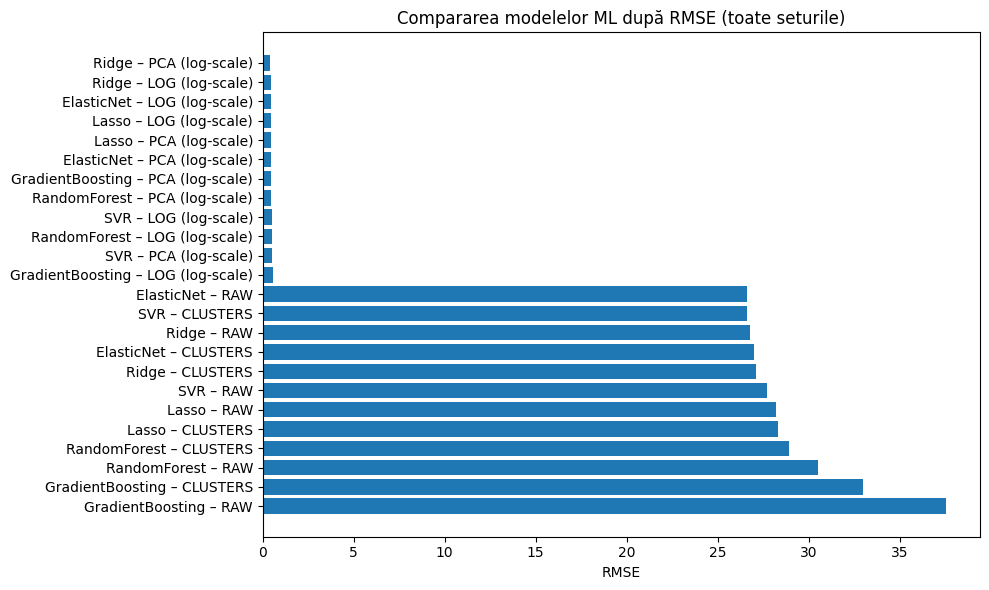

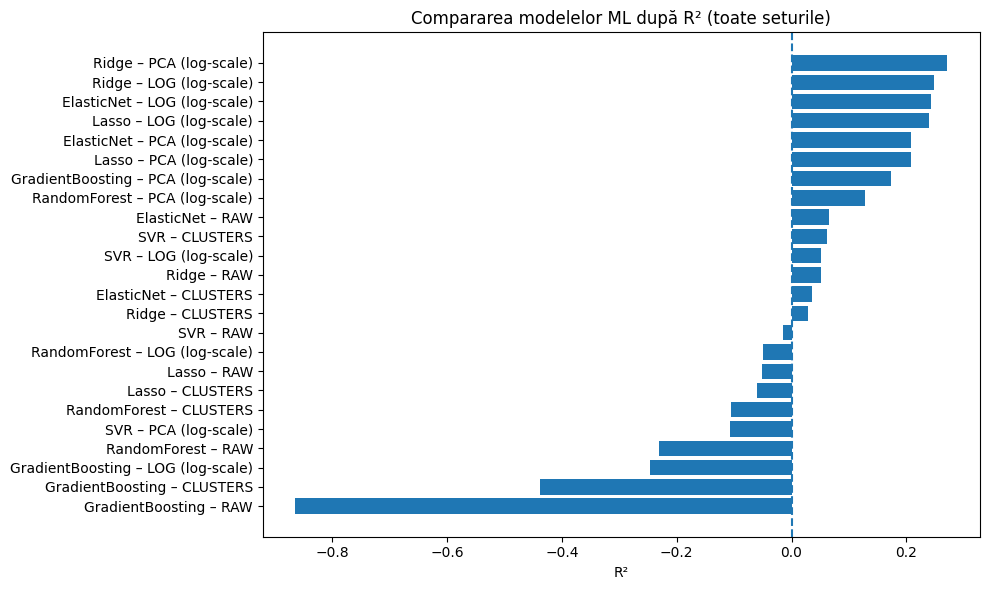

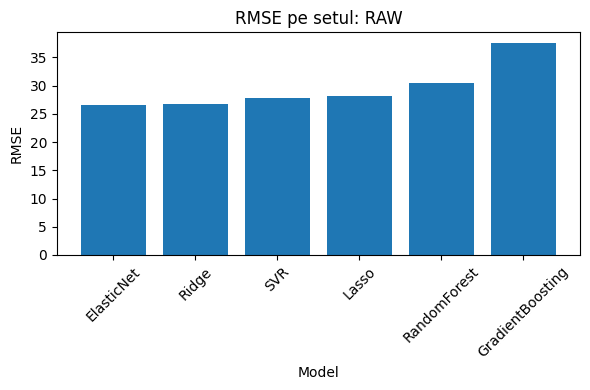

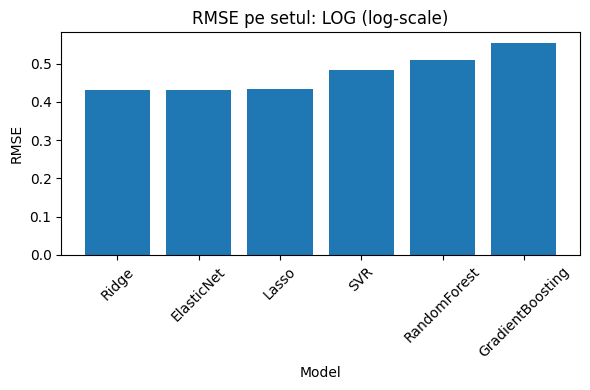

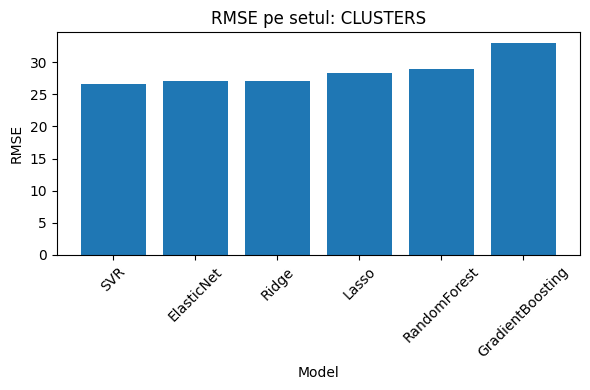

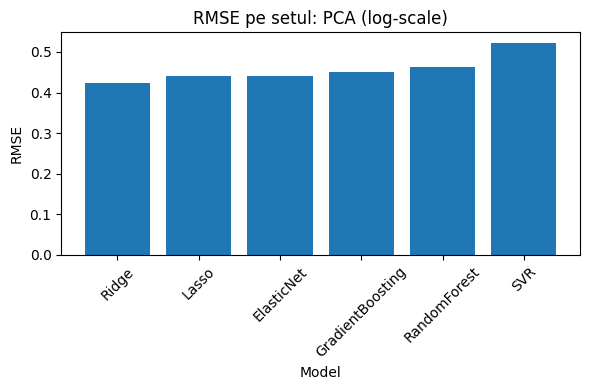

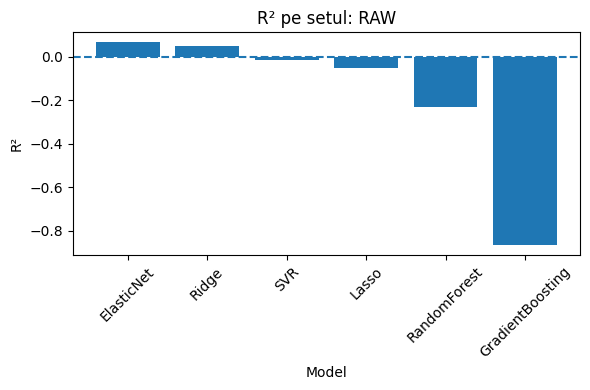

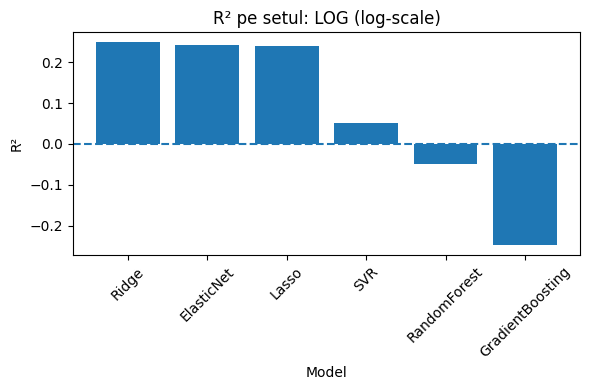

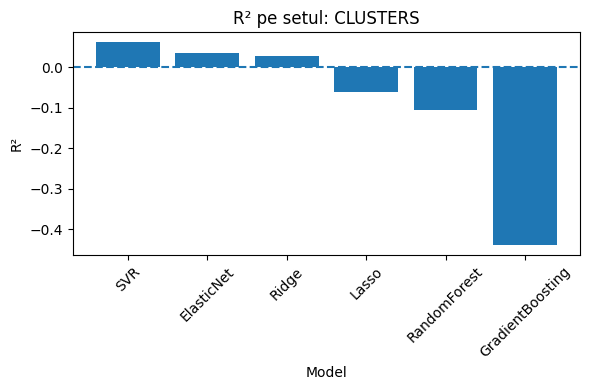

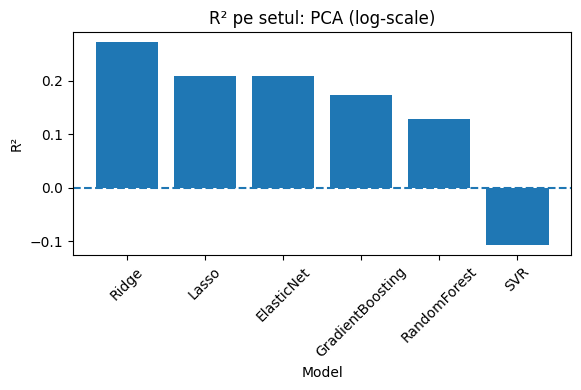

In [36]:
#   GRAFICE REZULTATE ML

# 1. Grafic global RMSE – toate modele + seturi

rmse_df = all_results.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(
    y=rmse_df.index,
    width=rmse_df["RMSE"]
)

plt.yticks(
    ticks=rmse_df.index,
    labels=rmse_df["Model"] + " – " + rmse_df["Dataset"]
)

plt.xlabel("RMSE")
plt.title("Compararea modelelor ML după RMSE (toate seturile)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Grafic global R² – toate modele + seturi

r2_df = all_results.sort_values(by="R2", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.barh(
    y=r2_df.index,
    width=r2_df["R2"]
)

plt.yticks(
    ticks=r2_df.index,
    labels=r2_df["Model"] + " – " + r2_df["Dataset"]
)

plt.xlabel("R²")
plt.title("Compararea modelelor ML după R² (toate seturile)")
plt.gca().invert_yaxis()
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()


# 3. RMSE separat pe fiecare dataset (RAW/LOG/PCA/CLUSTERS)

datasets_unique = all_results["Dataset"].unique()

for ds in datasets_unique:
    subset = all_results[all_results["Dataset"] == ds].sort_values(by="RMSE")

    plt.figure(figsize=(6, 4))
    plt.bar(
        x=subset["Model"],
        height=subset["RMSE"]
    )
    plt.xlabel("Model")
    plt.ylabel("RMSE")
    plt.title(f"RMSE pe setul: {ds}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 4. R² separat pe fiecare dataset

for ds in datasets_unique:
    subset = all_results[all_results["Dataset"] == ds].sort_values(by="R2", ascending=False)

    plt.figure(figsize=(6, 4))
    plt.bar(
        x=subset["Model"],
        height=subset["R2"]
    )
    plt.xlabel("Model")
    plt.ylabel("R²")
    plt.title(f"R² pe setul: {ds}")
    plt.xticks(rotation=45)
    plt.axhline(0, linestyle="--")
    plt.tight_layout()
    plt.show()


**Cele mai bune rezultate sunt obținute de modelul Ridge estimat pe datele PCA în log-scale, care atinge cea mai mică eroare de predicție și cel mai mare R²; în general, modelele liniare penalizate (Ridge, Lasso, ElasticNet) depășesc metodele neliniare, iar transformarea logaritmică și reducerea dimensionalității prin PCA îmbunătățesc semnificativ performanța predictivă.**
